In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# for t-test precip. mean
from scipy.stats import ttest_ind

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# # set fonts configuration - Arial
# matplotlib.rcParams['font.family'] = "Open Sans"
# matplotlib.rcParams['font.sans-serif'] = "Arial"

In [4]:
# data directoies
dir_mcs_env = Path('/scratch/wmtsai/temp_mcs/mcs_stats/envs_track')
dir_mcs_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs')

#### plotting functions 

In [20]:
def plot_BL_TOT(data_track, data_env_phase, subplots_ax, row_pos):
    
    data_track_sub = data_track.sel(tracks=track_number)
    idt_phase = [data_track_sub.idt_mcs_init, data_track_sub.idt_mcs_grow, 
                 data_track_sub.idt_mcs_mature, data_track_sub.idt_mcs_decay,
                 data_track_sub.idt_mcs_end]

    # plot mcs binary mask
    for n, (ax, phase, idt) in enumerate(zip(subplots_ax, data_env_phase.mcs_phase.values[1:],
                                            idt_phase)):
        
        ax.coastlines(color='k',linewidth=0.7)
        ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
        ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
        ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 
        
        meanlon = data_track_sub.meanlon.isel(times=idt).values
       
        lon = data_track_sub.meanlon.isel(times=idt).values + np.linspace(-5,5,40)
        lat = data_track_sub.meanlat.isel(times=idt).values + np.linspace(-5,5,40)
        
        if meanlon < 0: # if negative in longitude
            lon = lon + 360
        else:
            lon = lon
        
        mcs_mask = data_env_phase.sel(mcs_phase = phase).cloudtracknumber_nomergesplit
        ax.contour(lon, lat, mcs_mask, linewidths=2, levels=[0,1], colors=['m'], zorder=2,
                  transform=ccrs.PlateCarree())
        
        thetae_bl = data_env_phase.thetae_bl
        thetae_sat_lt = data_env_phase.thetae_sat_lt
        thetae_lt = data_env_phase.thetae_lt
        sp = data_env_phase.SP/100 # hPa

        delta_pl=sp-100-500
        delta_pb=100
        wb=(delta_pb/delta_pl)*np.log((delta_pl+delta_pb)/delta_pb)
        wl=1-wb

        # calculate buoyancy estimate: BL,tot = 9.8/(340*3)*(BL,cape - BL,subsat), weighting included
        Buoy_CAPE = wb * ((thetae_bl-thetae_sat_lt)/thetae_sat_lt) * 340
        Buoy_SUBSAT = wl * ((thetae_sat_lt-thetae_lt)/thetae_sat_lt) * 340        
        Buoy_TOT = Buoy_CAPE - Buoy_SUBSAT
        
        BL_TOT_phase = (9.8/(340*3))*Buoy_TOT.sel(mcs_phase = phase) # m/s^2

        cf = ax.pcolormesh(lon, lat, BL_TOT_phase, vmin=-0.12,vmax=0.02, cmap='jet',
                        zorder=1, transform=ccrs.PlateCarree())
        ax.contour(lon, lat, BL_TOT_phase, levels=[0,0.02], colors=['k'], linewidths=1,
                        zorder=2, transform=ccrs.PlateCarree())
        # if n == 4:
        #     cbaxes = fig.add_axes([0.91, 0.65, 0.01, 0.35])              
        #     cbar = plt.colorbar(cf, cax=cbaxes, shrink=0.5)
        #     cbar.set_label('Buoy. TOT (m/s$^{2}$)')
        
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='k', alpha=0.4, linestyle=':',xlabel_style={'size': 8},ylabel_style={'size': 8})
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        
    return cf

In [21]:
def plot_BL_SUBSAT(data_track, data_env_phase, subplots_ax, row_pos):
    
    data_track_sub = data_track.sel(tracks=track_number)
    idt_phase = [data_track_sub.idt_mcs_init, data_track_sub.idt_mcs_grow, 
                 data_track_sub.idt_mcs_mature, data_track_sub.idt_mcs_decay,
                 data_track_sub.idt_mcs_end]

    # plot mcs binary mask
    for n, (ax, phase, idt) in enumerate(zip(subplots_ax, data_env_phase.mcs_phase.values[1:],
                                            idt_phase)):
        
        ax.coastlines(color='k',linewidth=0.7)
        ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
        ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
        ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 
        
        meanlon = data_track_sub.meanlon.isel(times=idt).values
       
        lon = data_track_sub.meanlon.isel(times=idt).values + np.linspace(-5,5,40)
        lat = data_track_sub.meanlat.isel(times=idt).values + np.linspace(-5,5,40)
        
        if meanlon < 0: # if negative in longitude
            lon = lon + 360
        else:
            lon = lon
        
        mcs_mask = data_env_phase.sel(mcs_phase = phase).cloudtracknumber_nomergesplit
        ax.contour(lon, lat, mcs_mask, linewidths=2, levels=[0,1], colors=['m'], zorder=2,
                  transform=ccrs.PlateCarree())
        
        thetae_bl = data_env_phase.thetae_bl
        thetae_sat_lt = data_env_phase.thetae_sat_lt
        thetae_lt = data_env_phase.thetae_lt
        sp = data_env_phase.SP/100 # hPa

        delta_pl=sp-100-500
        delta_pb=100
        wb=(delta_pb/delta_pl)*np.log((delta_pl+delta_pb)/delta_pb)
        wl=1-wb

        # calculate buoyancy estimate: BL,tot = 9.8/(340*3)*(BL,cape - BL,subsat), weighting included
        Buoy_CAPE = wb * ((thetae_bl-thetae_sat_lt)/thetae_sat_lt) * 340
        Buoy_SUBSAT = wl * ((thetae_sat_lt-thetae_lt)/thetae_sat_lt) * 340        
        Buoy_TOT = Buoy_CAPE - Buoy_SUBSAT
        
        BL_SUBSAT_phase = (9.8/(340*3))*Buoy_SUBSAT.sel(mcs_phase = phase) # m/s^2

        cf = ax.pcolormesh(lon, lat, BL_SUBSAT_phase, vmin=0,vmax=0.1, cmap='terrain',
                        zorder=1, transform=ccrs.PlateCarree())
        #ax.contour(lon, lat, BL_SUBSAT_phase, levels=[0,0.02], colors=['k'], linewidths=1,
        #                zorder=2, transform=ccrs.PlateCarree())
        # if n == 4:
        #     cbaxes = fig.add_axes([0.91, 0.38, 0.01, 0.25])              
        #     cbar = plt.colorbar(cf, cax=cbaxes, shrink=0.35)
        #     cbar.set_label('Buoy. SUBSAT (m/s$^{2}$)')
             
        #timestamp_phase = data_track.base_time.sel(tracks=track_number, times=idt).values
        #ax.set_title('MCS phase: {}'.format(phase), fontsize=12, fontweight='bold')
        
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='k', alpha=0.4, linestyle=':',xlabel_style={'size': 8},ylabel_style={'size': 8})
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        
    return cf

In [24]:
def plot_era5_gpm_rainrate(data_track, data_env_phase, subplots_ax, row_pos):
        
    data_track_sub = data_track.sel(tracks=track_number)
    idt_phase = [data_track_sub.idt_mcs_init, data_track_sub.idt_mcs_grow, 
                 data_track_sub.idt_mcs_mature, data_track_sub.idt_mcs_decay,
                 data_track_sub.idt_mcs_end]
    phase_str = ['Initial','Growing','Mature','Decaying','Termination']
    # plot mcs binary mask
    for n, (ax, phase, idt, pstr) in enumerate(zip(subplots_ax, data_env_phase.mcs_phase.values[1:],
                                        idt_phase,
                                        phase_str)):
        
        ax.coastlines(color='k',linewidth=0.7)
        ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
        ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
        ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 
        
        meanlon = data_track_sub.meanlon.isel(times=idt).values
        
        lon = data_track_sub.meanlon.isel(times=idt).values + np.linspace(-5,5,40)
        lat = data_track_sub.meanlat.isel(times=idt).values + np.linspace(-5,5,40)
        
        if meanlon < 0: # if negative in longitude
            lon = lon + 360
        else:
            lon = lon
            
        # MCS mask
        mcs_mask = data_env_phase.sel(mcs_phase = phase).cloudtracknumber_nomergesplit
        ax.contour(lon, lat, mcs_mask, linewidths=2, levels=[0,1], colors=['m'], zorder=2, 
                   transform=ccrs.PlateCarree())
        
        # ERA-5 precip
        pr_phase = data_env_phase.sel(mcs_phase = phase).mtpr # (mm/hr)
        # GPM-IMERG precip
        pr_gpm_phase = data_env_phase.sel(mcs_phase = phase).precipitationCal # (mm/hr)

        # ERA-5 rainrate (shading)
        #pr_mask = pr_phase.where(pr_phase > 1) # larger than 1 mm/hr
        cf = ax.pcolormesh(lon, lat, pr_gpm_phase, cmap='jet', vmin=0.5, vmax=15,
                        transform=ccrs.PlateCarree())
        cf.cmap.set_under('w')
        # GPM rainrate (contours)
        ax.contour(lon, lat, pr_gpm_phase, levels=[2], colors=['skyblue'], transform=ccrs.PlateCarree())
        
#         if n == 4: # set colorbar on the far right 
#             cbaxes = fig.add_axes([0.91, 0.1, 0.01, 0.25])              
#             cbar = plt.colorbar(cf,cax=cbaxes, shrink=0.35)
#             #cbar.set_ticks([1,3,5,7,9,11])
#             cbar.set_label('GPM rainrate (mm/hr)')
           
        # text for mcs stats
        tot_rain = data_track_sub.isel(times=idt).total_rain.values
        area = data_track_sub.sel(times=idt).ccs_area.values
        mean_tot_rain = tot_rain/(area/100)
        t1 = ax.text(lon[0]+0.5, lat[-1]-1, s='Precip.: {} (mm/hr)'.format(np.round(mean_tot_rain,2)), fontsize=10, fontweight='bold',color='r')
        t1.set_bbox(dict(facecolor='w', alpha=0.5, edgecolor='w'))
        t2 = ax.text(lon[0]+0.5, lat[-1]-2, s='Area: {} (km$^2$)'.format(int(area)), fontsize=10, fontweight='bold',color='r')
        t2.set_bbox(dict(facecolor='w', alpha=0.5, edgecolor='w'))
        
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='k', alpha=0.4, linestyle=':',xlabel_style={'size': 8},ylabel_style={'size': 8})
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        
        timestamp_phase = data_track.base_time.sel(tracks=track_number, times=idt).values
        ax.set_title('MCS phase: {} \n {}'.format(pstr, str(timestamp_phase)[:13]), fontsize=10, fontweight='bold')
        
    return cf

#### Main codes: processing non2mcs data 

In [10]:
# get cases of high correlation 
year = 2020
feat_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/tracks_stats_phase/')
feat_stats = xr.open_dataset(feat_dir / 'featstats_tracks_non2mcs_{}.tropics30NS.full.nc'.format(year))

In [11]:
idx_HCC = np.where(feat_stats.corr_coeff_temp > 0.5)[0]

In [12]:
feat_stats.tracks.isel(tracks=idx_HCC)[100:200]

<xarray.DataArray 'tracks' (tracks: 100)> Size: 800B
array([1462, 1498, 1510, 1532, 1550, 1567, 1569, 1594, 1606, 1628, 1642, 1659,
       1701, 1713, 1714, 1735, 1775, 1786, 1800, 1805, 1817, 1820, 1838, 1927,
       1934, 1940, 1959, 1970, 1985, 2012, 2027, 2041, 2050, 2067, 2077, 2084,
       2126, 2186, 2211, 2224, 2226, 2232, 2240, 2254, 2265, 2291, 2300, 2302,
       2339, 2360, 2381, 2389, 2395, 2407, 2411, 2457, 2466, 2504, 2507, 2509,
       2560, 2573, 2614, 2636, 2657, 2673, 2679, 2686, 2693, 2704, 2707, 2721,
       2751, 2768, 2778, 2796, 2797, 2802, 2805, 2809, 2844, 2853, 2858, 2862,
       2873, 2890, 2900, 2903, 2909, 2915, 2921, 2927, 2934, 2936, 2956, 2965,
       2999, 3020, 3059, 3061])
Coordinates:
  * tracks   (tracks) int64 800B 1462 1498 1510 1532 ... 2999 3020 3059 3061

CPU times: user 13 s, sys: 5.87 s, total: 18.9 s
Wall time: 12.3 s


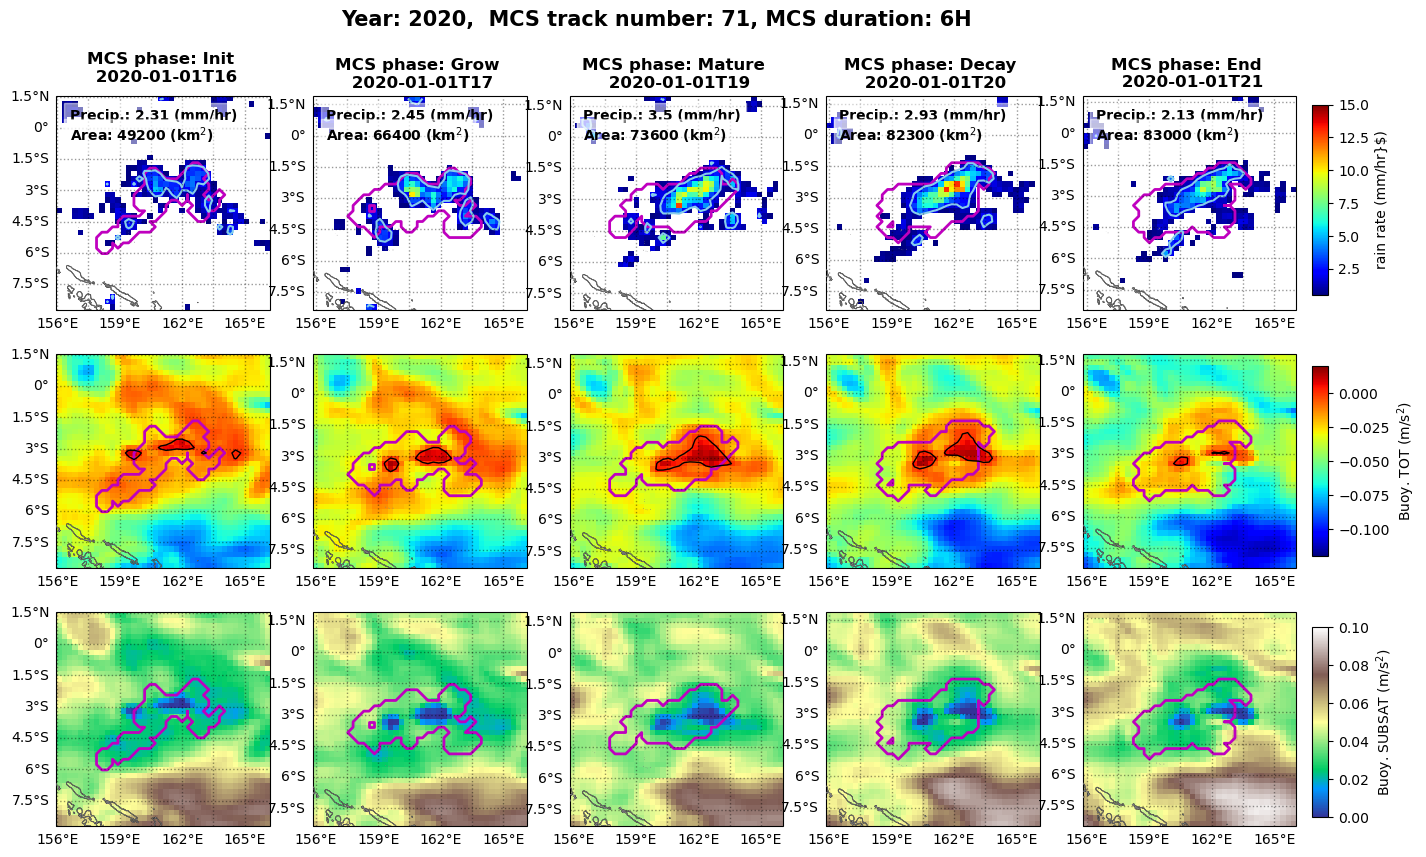

In [13]:
%%time
year = 2020

data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.full.nc'.format(year))
dir_env_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/envs_track/{}/tropics_extend'.format(year))

# find selected MCS-env data with the ID accordingly
track_number = 71
data_env_phase = xr.open_dataset(dir_env_track / 'mcs_era5_3D_envs_{}.{}.LD.nc'.format(year,str(track_number).zfill(5)))

start_basetime = data_track.sel(tracks=track_number).start_basetime.values
timestamp_str = str(start_basetime)
year = timestamp_str[:4]
month = timestamp_str[5:7]
day = timestamp_str[8:10]
hour = timestamp_str[11:13]

# MCS initial time centroid
idt_init = data_track.sel(tracks=track_number).idt_mcs_init.values
meanlon = data_track.sel(tracks=track_number, times=idt_init).meanlon
meanlat = data_track.sel(tracks=track_number, times=idt_init).meanlat

if meanlon < 0: # if negative in longitude
    meanlon_era5 = meanlon + 360
else:
    meanlon_era5 = meanlon

fig, ((ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10),(ax11,ax12,ax13,ax14,ax15)) = plt.subplots(3,5,figsize=(16,9.5),
                                                                  subplot_kw={'projection': ccrs.PlateCarree()})
cf1 = plot_era5_gpm_rainrate(data_track, data_env_phase,[ax1,ax2,ax3,ax4,ax5], row_pos=3)
cf2 = plot_BL_TOT(data_track, data_env_phase, [ax6,ax7,ax8,ax9,ax10], row_pos=1)
cf3 = plot_BL_SUBSAT(data_track, data_env_phase, [ax11,ax12,ax13,ax14,ax15], row_pos=2)

# set colorbar position (Don't change the figure size and location)
cbaxes1 = fig.add_axes([0.91, 0.67, 0.01, 0.2])              
cbar1 = plt.colorbar(cf1, cax=cbaxes1, shrink=0.35)
cbar1.set_label('rain rate (mm/hr}$)')

cbaxes2 = fig.add_axes([0.91, 0.395, 0.01, 0.2])              
cbar2 = plt.colorbar(cf2, cax=cbaxes2, shrink=0.35)
cbar2.set_label('Buoy. TOT (m/s$^{2}$)')

cbaxes3 = fig.add_axes([0.91, 0.12, 0.01, 0.2])              
cbar3 = plt.colorbar(cf3, cax=cbaxes3, shrink=0.35)
cbar3.set_label('Buoy. SUBSAT (m/s$^{2}$)')

plt.suptitle('Year: {},  MCS track number: {}, MCS duration: {}H'.format(year,
                                                                      data_track.sel(tracks=track_number).tracks.values,
                                                                      data_track.sel(tracks=track_number).mcs_duration.values
                                                     ), fontsize=15, fontweight='bold', y=0.97);

#plt.tight_layout()
fig.savefig('/scratch/wmtsai/temp_mcs/fig/MCStrack_phase_evolution.example.png', dpi=300,
           bbox_inches='tight', transparent=False)

CPU times: user 5.5 s, sys: 5.51 s, total: 11 s
Wall time: 4.57 s


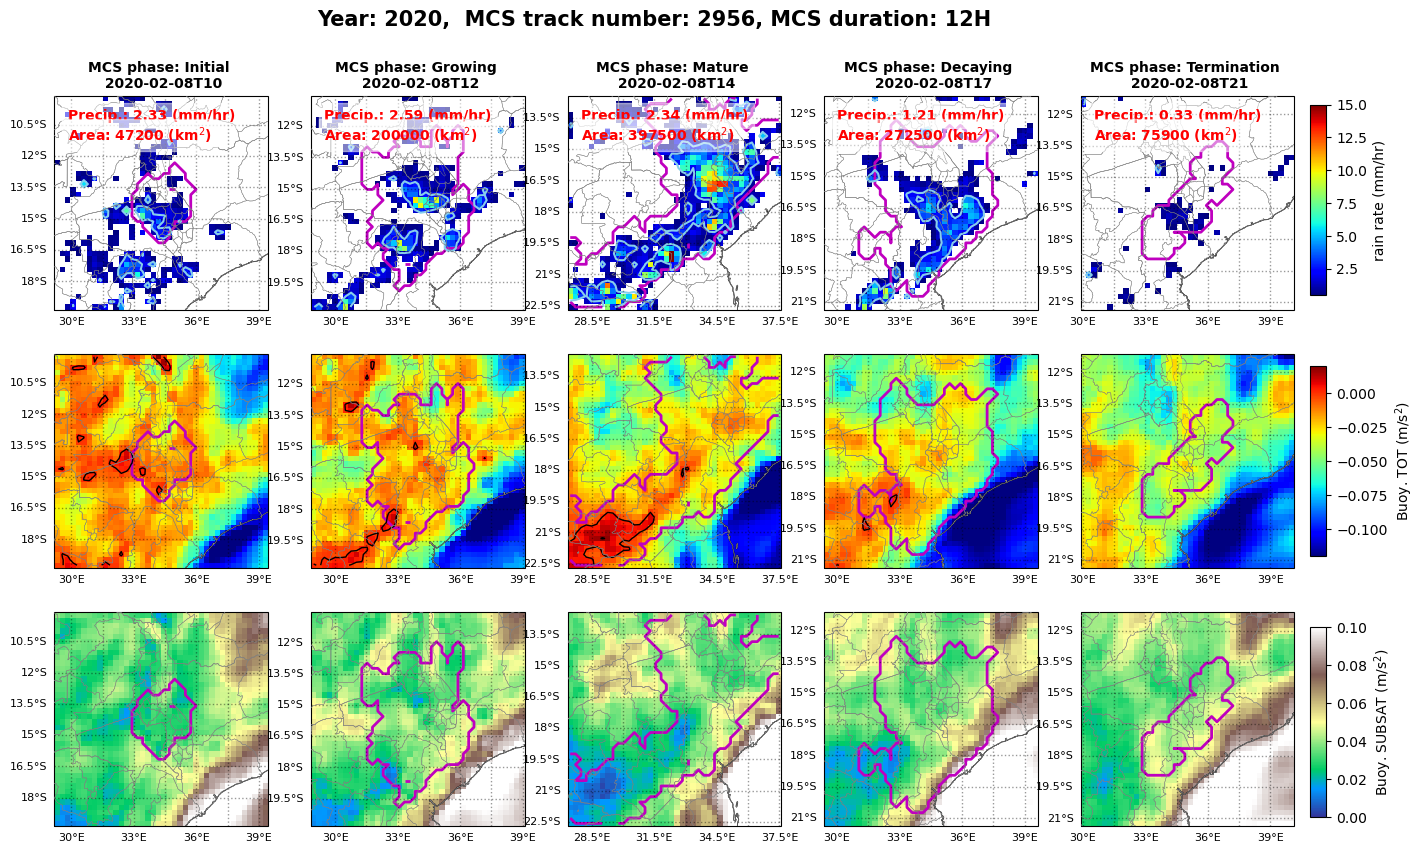

In [26]:
%%time
year = 2020

data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))
dir_env_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/envs_track/{}/tropics_extend'.format(year))

# find selected MCS-env data with the ID accordingly
track_number = 2956
data_env_phase = xr.open_dataset(dir_env_track / 'mcs_era5_3D_envs_{}.{}.LD.nc'.format(year,str(track_number).zfill(5)))

start_basetime = data_track.sel(tracks=track_number).start_basetime.values
timestamp_str = str(start_basetime)
year = timestamp_str[:4]
month = timestamp_str[5:7]
day = timestamp_str[8:10]
hour = timestamp_str[11:13]

# MCS initial time centroid
idt_init = data_track.sel(tracks=track_number).idt_mcs_init.values
meanlon = data_track.sel(tracks=track_number, times=idt_init).meanlon
meanlat = data_track.sel(tracks=track_number, times=idt_init).meanlat

if meanlon < 0: # if negative in longitude
    meanlon_era5 = meanlon + 360
else:
    meanlon_era5 = meanlon

fig, ((ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10),(ax11,ax12,ax13,ax14,ax15)) = plt.subplots(3,5,figsize=(16,9.5),
                                                                  subplot_kw={'projection': ccrs.PlateCarree()})
cf1 = plot_era5_gpm_rainrate(data_track, data_env_phase,[ax1,ax2,ax3,ax4,ax5], row_pos=3)
cf2 = plot_BL_TOT(data_track, data_env_phase, [ax6,ax7,ax8,ax9,ax10], row_pos=1)
cf3 = plot_BL_SUBSAT(data_track, data_env_phase, [ax11,ax12,ax13,ax14,ax15], row_pos=2)

# set colorbar position (Don't change the figure size and location)
cbaxes1 = fig.add_axes([0.91, 0.67, 0.01, 0.2])              
cbar1 = plt.colorbar(cf1, cax=cbaxes1, shrink=0.35)
cbar1.set_label('rain rate (mm/hr)')

cbaxes2 = fig.add_axes([0.91, 0.395, 0.01, 0.2])              
cbar2 = plt.colorbar(cf2, cax=cbaxes2, shrink=0.35)
cbar2.set_label('Buoy. TOT (m/s$^{2}$)')

cbaxes3 = fig.add_axes([0.91, 0.12, 0.01, 0.2])              
cbar3 = plt.colorbar(cf3, cax=cbaxes3, shrink=0.35)
cbar3.set_label('Buoy. SUBSAT (m/s$^{2}$)')

plt.suptitle('Year: {},  MCS track number: {}, MCS duration: {}H'.format(year,
                                                                      data_track.sel(tracks=track_number).tracks.values,
                                                                      data_track.sel(tracks=track_number).mcs_duration.values
                                                     ), fontsize=15, fontweight='bold', y=0.97)

#plt.tight_layout()
fig.savefig('/scratch/wmtsai/temp_mcs/fig/FigS1_MCStrack_phase_evolution.SouthAfrica.png', dpi=300,
         bbox_inches='tight', transparent=False)

CPU times: user 7.24 s, sys: 235 ms, total: 7.48 s
Wall time: 7.49 s


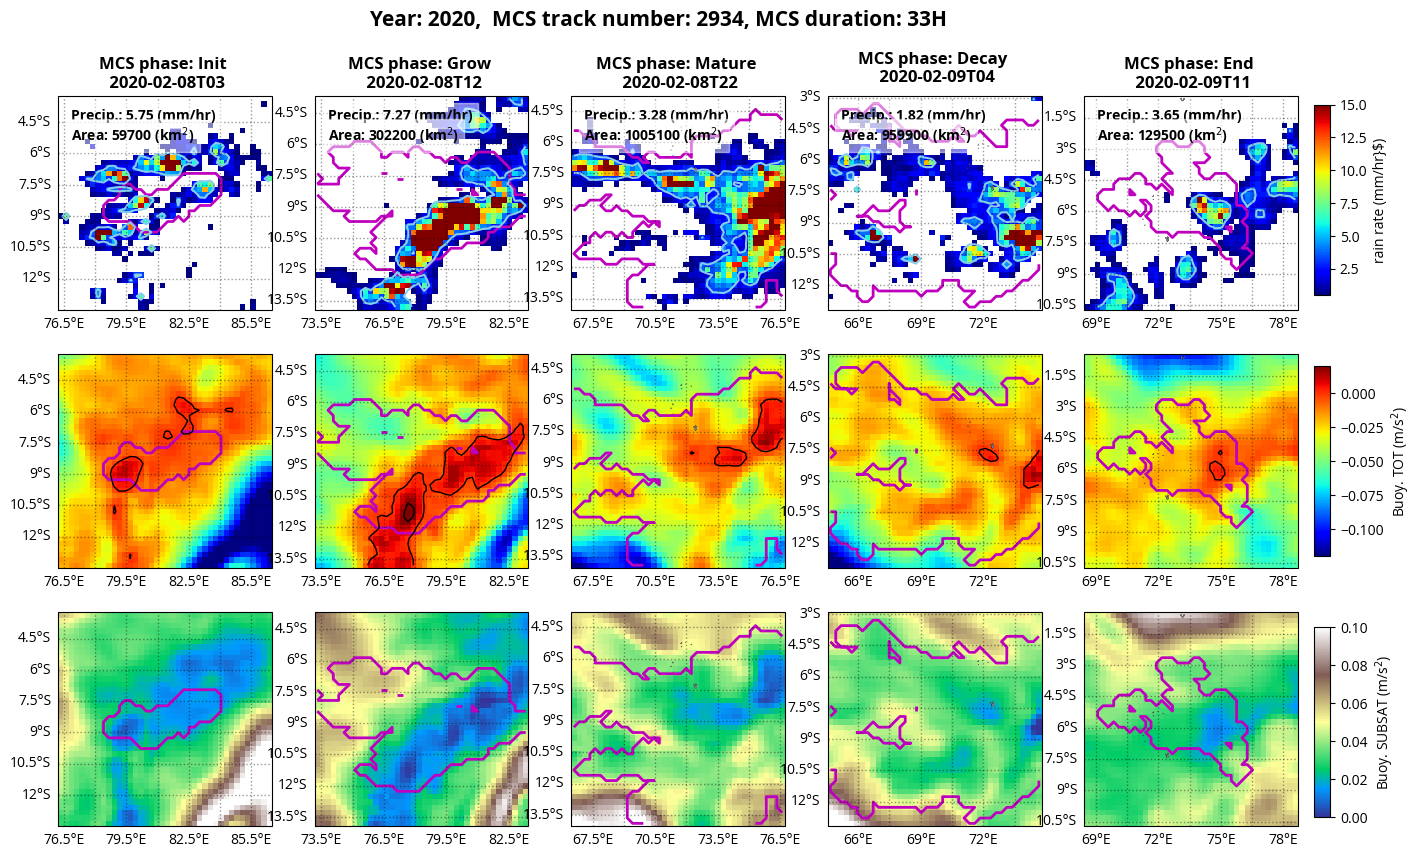

In [23]:
%%time
year = 2020

data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))
dir_env_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/envs_track/{}/tropics_extend'.format(year))

# find selected MCS-env data with the ID accordingly
track_number = 2934
data_env_phase = xr.open_dataset(dir_env_track / 'mcs_era5_3D_envs_{}.{}.LD.nc'.format(year,str(track_number).zfill(5)))

start_basetime = data_track.sel(tracks=track_number).start_basetime.values
timestamp_str = str(start_basetime)
year = timestamp_str[:4]
month = timestamp_str[5:7]
day = timestamp_str[8:10]
hour = timestamp_str[11:13]

# MCS initial time centroid
idt_init = data_track.sel(tracks=track_number).idt_mcs_init.values
meanlon = data_track.sel(tracks=track_number, times=idt_init).meanlon
meanlat = data_track.sel(tracks=track_number, times=idt_init).meanlat

if meanlon < 0: # if negative in longitude
    meanlon_era5 = meanlon + 360
else:
    meanlon_era5 = meanlon

fig, ((ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10),(ax11,ax12,ax13,ax14,ax15)) = plt.subplots(3,5,figsize=(16,9.5),
                                                                  subplot_kw={'projection': ccrs.PlateCarree()})
cf1 = plot_era5_gpm_rainrate(data_track, data_env_phase,[ax1,ax2,ax3,ax4,ax5], row_pos=3)
cf2 = plot_BL_TOT(data_track, data_env_phase, [ax6,ax7,ax8,ax9,ax10], row_pos=1)
cf3 = plot_BL_SUBSAT(data_track, data_env_phase, [ax11,ax12,ax13,ax14,ax15], row_pos=2)

# set colorbar position (Don't change the figure size and location)
cbaxes1 = fig.add_axes([0.91, 0.67, 0.01, 0.2])              
cbar1 = plt.colorbar(cf1, cax=cbaxes1, shrink=0.35)
cbar1.set_label('rain rate (mm/hr}$)')

cbaxes2 = fig.add_axes([0.91, 0.395, 0.01, 0.2])              
cbar2 = plt.colorbar(cf2, cax=cbaxes2, shrink=0.35)
cbar2.set_label('Buoy. TOT (m/s$^{2}$)')

cbaxes3 = fig.add_axes([0.91, 0.12, 0.01, 0.2])              
cbar3 = plt.colorbar(cf3, cax=cbaxes3, shrink=0.35)
cbar3.set_label('Buoy. SUBSAT (m/s$^{2}$)')

plt.suptitle('Year: {},  MCS track number: {}, MCS duration: {}H'.format(year,
                                                                      data_track.sel(tracks=track_number).tracks.values,
                                                                      data_track.sel(tracks=track_number).mcs_duration.values
                                                     ), fontsize=15, fontweight='bold', y=0.97);
#plt.tight_layout()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/MCStrack_phase_evolution.MJOlike.png', dpi=300,
           bbox_inches='tight', transparent=False)